In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import pandas_profiling as pp

from scipy import stats as sps

from io import BytesIO, StringIO

%matplotlib inline

## To Do

1. Use Plotly
1. Determine Optimal Sigma at PH level

palette1 = https://www.color-hex.com/color-palette/15945  
palette2 = https://www.color-hex.com/color-palette/1407

## Load Data

Data is from [DOH's Data Drop](https://drive.google.com/open?id=1-rUCIfDkx9jj4EFCkIqsjGwmc9Los_Pp).

The [trick](https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public) to loading the csv file to pandas is to get the file id and use request to load the raw csv into into pandas.

In [2]:
# src = 'https://drive.google.com/open?id=1AC_x8c1HEgVV997VaeQuJ--viBpbBY_j'
src = 'https://drive.google.com/open?id=1X_JPTiGr8q12ujnnelDpcpQcMm91AL9T'
file_id = src.split('=')[1]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw)

# format date columns
for col in df.columns:
    if 'Date' in col:
        df[col] = pd.to_datetime(df[col])
df.head(10)

,CaseCode,Age,AgeGroup,Sex,DateRepConf,DateRecover,DateDied,RemovalType,DateRepRem,Admitted,HealthStatus,RegionRes,ProvRes,CityMunRes,RegionPSGC,ProvPSGC,CityMuniPSGC
0,C100119,30.0,30 to 34,Male,2020-04-12,NaT,NaT,NaN,NaT,Yes,Asymptomatic,NCR,NCR,City of ParaÃ±aque,PH130000000,PH137600000,PH137604000
1,C100264,57.0,55 to 59,Male,2020-03-29,NaT,NaT,NaN,NaT,Yes,Mild,NCR,NCR,City of Mandaluyong,PH130000000,PH137400000,PH137401000
2,C100648,33.0,30 to 34,Female,2020-04-16,NaT,NaT,NaN,NaT,Yes,Mild,NCR,NCR,Quezon City,PH130000000,PH137400000,PH137404000
3,C100660,42.0,40 to 44,Female,2020-04-02,NaT,NaT,NaN,NaT,Yes,Mild,NCR,NCR,City of Pasig,PH130000000,PH137400000,PH137403000
4,C100776,42.0,40 to 44,Male,2020-04-01,NaT,NaT,NaN,NaT,Yes,Mild,4A,Laguna,Pila,PH040000000,PH043400000,PH043422000
5,C101015,79.0,75 to 79,Male,2020-04-03,NaT,NaT,NaN,NaT,Yes,Mild,4A,Quezon,Unisan,PH040000000,PH045600000,PH045649000
6,C101097,33.0,30 to 34,Male,2020-03-27,NaT,NaT,NaN,NaT,Yes,Mild,NCR,NCR,Quezon City,PH130000000,PH137400000,PH137404000
7,C101232,30.0,30 to 34,Male,2020-03-21,2020-03-25,NaT,Recovered,2020-03-28,Yes,Recovered,NCR,NCR,City of Mandaluyong,PH130000000,PH137400000,PH137401000
8,C101376,29.0,25 to 29,Male,2020-04-11,NaT,NaT,NaN,NaT,Yes,Mild,NCR,NaN,NaN,NaN,NaN,NaN
9,C101483,40.0,40 to 44,Female,2020-04-14,NaT,NaT,NaN,NaT,NaN,Mild,NCR,NCR,City of San Juan,PH130000000,PH137400000,PH137405000


## Latest Statistics

In [3]:
total_cases = len(df)
recovered = len(df.loc[df.RemovalType=='Recovered'])
died = len(df.loc[df.RemovalType=='Died'])
active_cases = total_cases - recovered - died
percent_active = active_cases / total_cases
percent_recovered = recovered / total_cases
percent_died = died / total_cases

print(f'Total Cases: {total_cases} \nActive Cases: {active_cases}\
({100*percent_active:.1f}% of total cases)\n\
Recovered: {recovered} ({100*percent_recovered:.1f}% of total cases)\n\
Died: {died} ({100*percent_died:.1f}% of total cases)')

Total Cases: 7958 
Active Cases: 6453(81.1% of total cases)
Recovered: 975 (12.3% of total cases)
Died: 530 (6.7% of total cases)


## Daily Trend of Total and Active Cases,  Recovered, and Died

### Total Cases Per Day

/Users/User/opt/anaconda3/envs/covid19/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/User/opt/anaconda3/envs/covid19/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/User/opt/anaconda3/envs/covid19/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


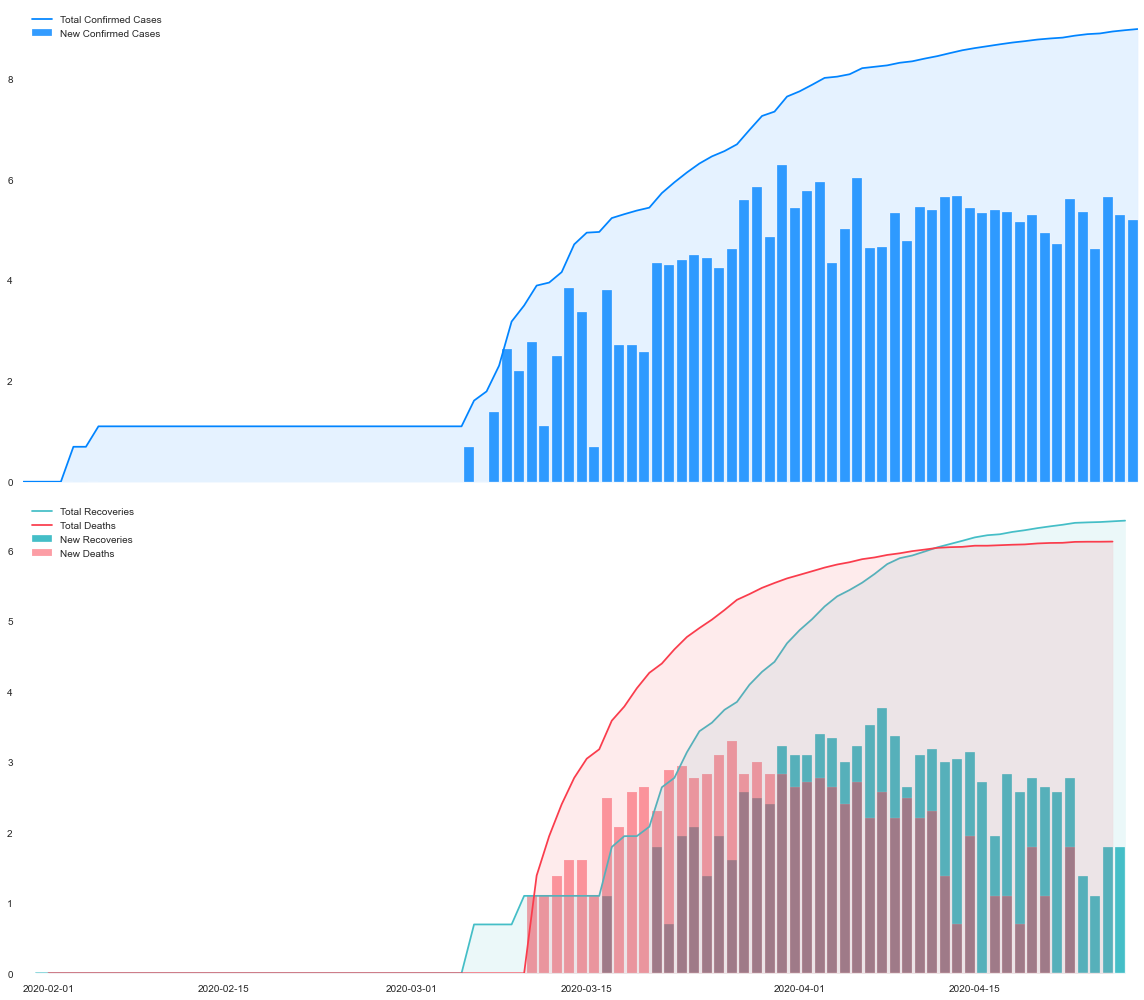

In [4]:
fig, ax = plt.subplots(2, figsize=(16, 14), sharex=True)

cases_per_day = (df.groupby('DateRepConf')['CaseCode']
                 .count().resample('1D').sum())

ax_ = ax[0]
x = cases_per_day.index.date
ax_.plot(x, np.log(cases_per_day.cumsum()), color='#0084ff',
        label='Total Confirmed Cases')
ax_.fill_between(x, y1=0, y2=np.log(cases_per_day.cumsum()), alpha=.1,
                color='#0084ff', label='')
ax_.bar(x, np.log(cases_per_day), color='#0084ff', alpha=.8,
       label='New Confirmed Cases', align='edge', width=-.8)
ax_.set_ylim(0,)
ax_.set_xlim(cases_per_day.index[0], cases_per_day.index[-1])
ax_.legend()

# recoveries
recoveries_per_day = (df.loc[df.RemovalType=='Recovered']
                      .groupby('DateRecover')['CaseCode']
                      .count().resample('1D').sum())

x = recoveries_per_day.index.date
ax_ = ax[1]
ax_.plot(x, np.log(recoveries_per_day.cumsum()),
         color='#44bec7', label='Total Recoveries', zorder=2)
ax_.fill_between(x, y1=0, y2=np.log(recoveries_per_day.cumsum()),
                 color='#44bec7', label='', alpha=.1, zorder=2)
ax_.bar(x, np.log(recoveries_per_day), color='#44bec7', alpha=1,
        label='New Recoveries', align='edge', width=-.8, zorder=0)

# deaths
deaths_per_day = (df.loc[df.RemovalType=='Died']
                  .groupby('DateDied')['CaseCode']
                  .count().resample('1D').sum())

x = deaths_per_day.index.date
ax_.plot(x, np.log(deaths_per_day.cumsum()),
         color='#fa3c4c', label='Total Deaths', zorder=3)
ax_.fill_between(x, y1=0, y2=np.log(deaths_per_day.cumsum()),
                 color='#fa3c4c', label='', alpha=.1, zorder=3)
ax_.bar(x, np.log(deaths_per_day), color='#fa3c4c', alpha=.5,
        label='New Deaths', align='edge', width=-.8, zorder=1)
ax_.set_ylim(0,)
ax_.set_xlim(cases_per_day.index[0], cases_per_day.index[-1])
ax_.legend()

fig.tight_layout();

### Percent Active, Recovered, and Died

In [5]:
dates = (df.loc[:, ['DateRepConf']].drop_duplicates()
         .sort_values(by='DateRepConf')
         .set_index('DateRepConf')
         .resample('D').sum())
dates.head()

""
DateRepConf
2020-01-30
2020-01-31
2020-02-01
2020-02-02
2020-02-03


In [6]:
total = []
active = []
recovered = []
died = []
for i in range(len(dates)):
    df_outcomes = df[df.DateRepRem <= dates.iloc[i].name]
    df_total = df[df.DateRepConf <= dates.iloc[i].name]

    t = len(df_total)
    r = len(df_outcomes.loc[df_outcomes.RemovalType == 'Recovered'])
    d = len(df_outcomes.loc[df_outcomes.RemovalType == 'Died'])
    a = t - r - d
    total.append(t)
    active.append(a)
    recovered.append(r)
    died.append(d)

df_cummu_daily = pd.DataFrame({'total': total, 'active': active,
                               'recovered': recovered, 'died': died},
                              index=dates.index)
df_cummu_daily.tail()

,total,active,recovered,died
DateRepConf,,,,
2020-04-24,7192,5953,762,477
2020-04-25,7294,6008,792,494
2020-04-26,7579,6216,862,501
2020-04-27,7777,6334,932,511
2020-04-28,7958,6453,975,530


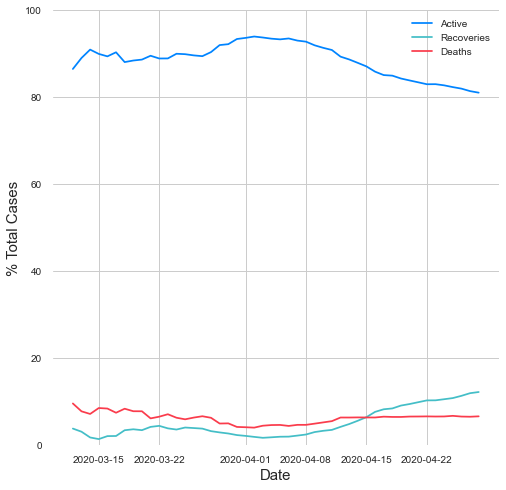

In [7]:
percent_active_per_day = (100 * df_cummu_daily.active / df_cummu_daily.total)
percent_deaths_per_day = (100 * df_cummu_daily.died / df_cummu_daily.total)
percent_recoveries_per_day = (100 * df_cummu_daily.recovered / df_cummu_daily.total)

fig, ax = plt.subplots(figsize=(8, 8))
x = df_cummu_daily.iloc[42:].index
ax.plot(x, percent_active_per_day[x],
        color='#0084ff', label='Active')
ax.plot(x, percent_recoveries_per_day[x], color='#44bec7', label='Recoveries')
ax.plot(x, percent_deaths_per_day[x], color='#fa3c4c', label='Deaths')
ax.set_ylim(0, 100)
ax.set_xlabel('Date', size=15)
ax.set_ylabel('% Total Cases', size=15)
ax.legend()
ax.grid(True)

While the number of total cases is still rising, the number of patients that recovered are also increasing.

### Naive Fatality Rate Estimation

Due to the nature of the data, we cannot reliably estimate the final fatality rate yet. However, we can provide an initial interval estimate using (1) total number of deaths over total cases and (2) total number of deaths over total number of cases with outcomes.

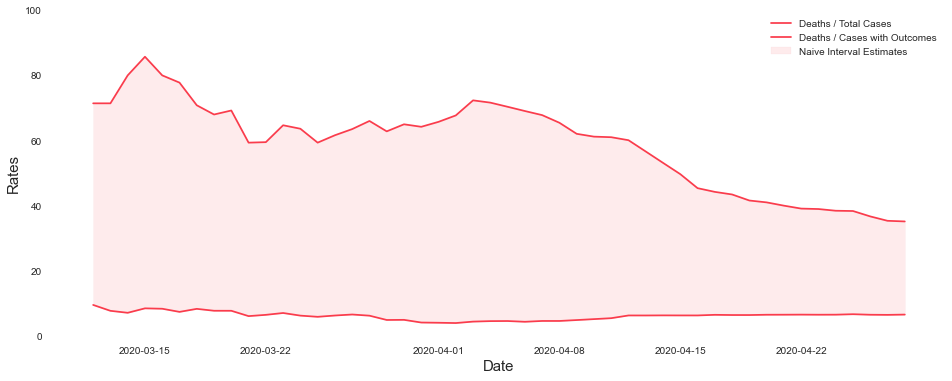

In [8]:
df_outcomes = 100 * df_cummu_daily.died / df_cummu_daily.iloc[:, 2:].sum(axis=1)
df_curr_rate = 100 * df_cummu_daily.died / df_cummu_daily.total

fig, ax = plt.subplots(figsize=(16, 6))
x = df_cummu_daily.iloc[42:].index
# ax.plot(x, df_curr_rate[x],
#         color='#0084ff', label='Active')
# ax.plot(x, df_outcomes[x])
ax.fill_between(x, y1=df_curr_rate[x], y2=df_outcomes[x], alpha=.1,
                color='#fa3c4c',
                label='Naive Interval Estimates')
ax.plot(x, df_curr_rate[x], color='#fa3c4c', label='Deaths / Total Cases')
ax.plot(x, df_outcomes[x], color='#fa3c4c', label='Deaths / Cases with Outcomes')
ax.set_ylim(0, 100)
ax.set_xlabel('Date', size=15)
ax.set_ylabel('Rates', size=15)
ax.legend()

We see that the daily deaths / total cases seems relatively fixed while deaths / cases with outcomes are declining.

### What is the proportion by Health Status per Day?

### What is the proportion by Age Group per Day?

### Time to Recovery/Death

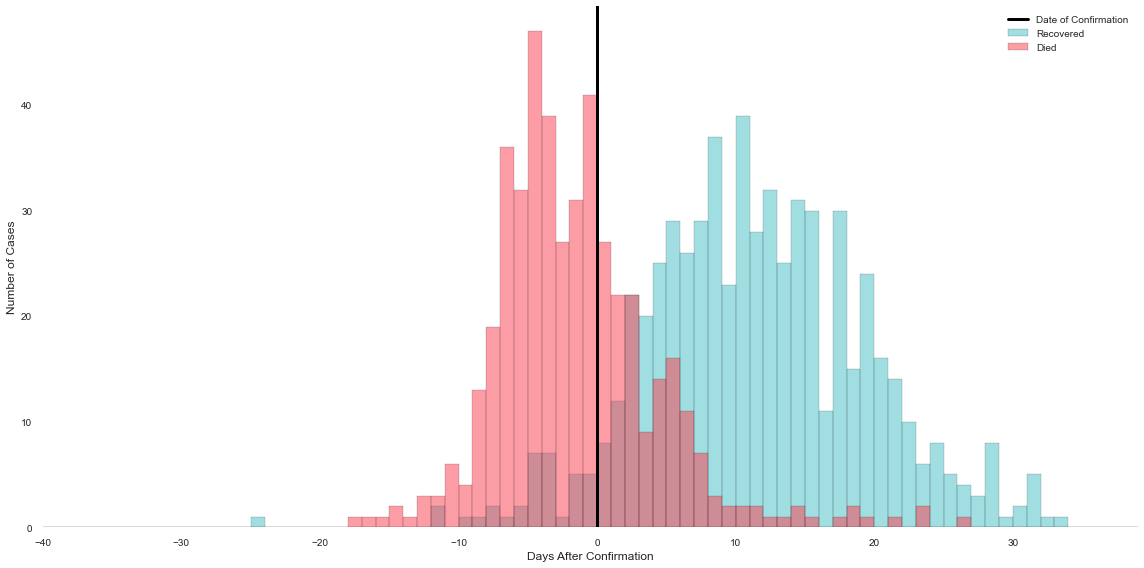

In [9]:
df_recovered = df.loc[(df.RemovalType=='Recovered')]
df_died = df.loc[(df.RemovalType=='Died')]

fig, ax = plt.subplots(figsize=(16, 8))
bins = np.arange(-40, 40)
((df_recovered.DateRecover - df_recovered.DateRepConf)
 .dt.days.hist(bins=bins, edgecolor='k', label='Recovered',
               facecolor='#44bec7', alpha=.5, ax=ax))

((df_died.DateDied - df_died.DateRepConf)
 .dt.days.hist(bins=bins, edgecolor='k', label='Died',
                    facecolor='#fa3c4c', alpha=.5, ax=ax))
ax.axvline(0, label='Date of Confirmation', linewidth=3, color='k')
ax.set_xlim(bins[0], bins[-1])
ax.grid(False)
ax.legend()
ax.set_ylabel('Number of Cases', size=12)
ax.set_xlabel('Days After Confirmation', size=12)
fig.tight_layout()

### Is It Getting Under Control?

#### New Cases VS Total Cases

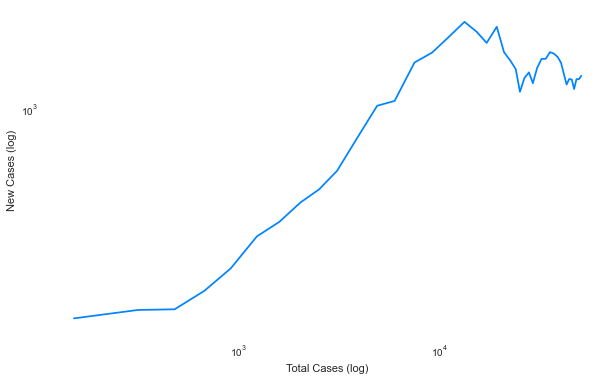

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(cases_per_day[x].rolling(window=7).sum().cumsum(),
          cases_per_day[x].rolling(window=7).sum(), color='#0084ff')
# ax.loglog(cases_per_day[x].rolling(window=7).sum().cumsum().iloc[27],
#           cases_per_day[x].rolling(window=7).sum().iloc[27],
#           color='k', marker='o')
# ax.loglog(cases_per_day[x].rolling(window=7).sum().cumsum().iloc[18],
#           cases_per_day[x].rolling(window=7).sum().iloc[18],
#           color='red', marker='o')
ax.set_xlabel('Total Cases (log)')
ax.set_ylabel('New Cases (log)');

Based on the plot above, the trend of new cases relative to total cases in log-log scale has become negative. This means that compared to the total cases, the growth in the number of new cases has slowed down.

#### Tests Performed Daily and Percent Positive

In [11]:
# url = 'https://drive.google.com/open?id=1f-R_LDq75nxzP0IjyzHCTVNLd1BbII5N'
url = 'https://drive.google.com/open?id=1E7cpkihKtojkyuoy2UMYuSlMn8NsHu7D'
file_id = url.split('=')[1]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df_tests = pd.read_csv(csv_raw)

# format date
df_tests['Date'] = pd.to_datetime(df_tests['Date'])

# format count columns
cols = [col for col in df_tests.columns if 'INDIVIDUALS' in col]
for col in cols:
    df_tests[col] = df_tests[col].str.replace(',', '').astype(int)
        
df_tests.head()

,Name of Health Facility/Laboratory,Abbrev of Health Facility,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,% positive/ unique individuals,NEGATIVE INDIVIDUALS,% negative/ unique individuals,EQUIVOCAL,% equivocal /unique individuals,INVALID,% invalid /unique individuals,TOTAL TESTS CONDUCTED,%,REMAINING AVAILABLE TESTS,%.1,Date
0,Research Institute for Tropical Medicine (RITM),RITM,NaN,NaN,NaN,15197,2652,17%,11367,75%,32,0.20%,NaN,NaN,"20,826",NaN,"75,396",NaN,2020-04-02
1,Baguio General Hospital and Medical Center (BG...,BGHMC,NaN,NaN,NaN,473,21,4%,452,96%,0,0.00%,NaN,NaN,478,NaN,"4,519",NaN,2020-04-02
2,San Lazaro Hospital (SLH),SLH,NaN,NaN,NaN,115,31,27%,84,73%,0,0.00%,NaN,NaN,193,NaN,"4,846",NaN,2020-04-02
3,Vicente Sotto Memorial Medical Center (VSMMC),VSMMC,NaN,NaN,NaN,672,37,6%,634,94%,1,0.10%,NaN,NaN,672,NaN,"23,812",NaN,2020-04-02
4,UP National Institutes of Health (UP-NIH),UP-NIH,NaN,NaN,NaN,332,43,13%,279,84%,10,3.00%,NaN,NaN,335,NaN,"4,565",NaN,2020-04-02


In [12]:
df_test_counts = df_tests.groupby('Date')[cols].sum().resample('1D').sum()
df_test_counts.tail()

,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,NEGATIVE INDIVIDUALS
Date,,,
2020-04-23,68765,8645,60004
2020-04-24,72794,8924,63733
2020-04-25,76030,9262,66640
2020-04-26,80858,9586,71142
2020-04-27,85596,9906,75553


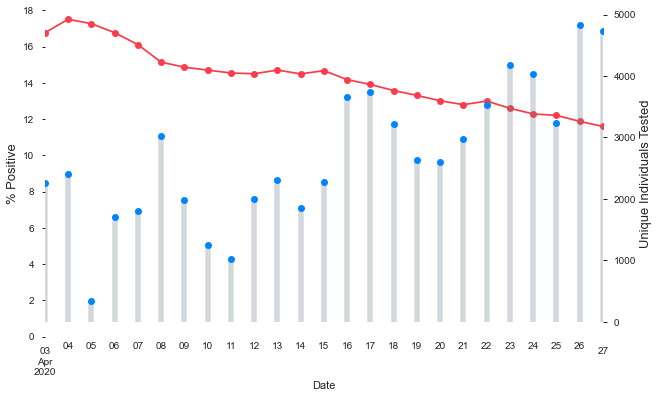

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

percent_positive = (100*df_test_counts.iloc[:, 1] / 
                    df_test_counts.iloc[:, 1:].sum(axis=1))
percent_positive.plot(ax=ax, color='#fa3c4c', marker='o')
ax.set_ylabel('% Positive', fontsize=13)
ax.set_ylim(0, 18)

ax2 = ax.twinx()
daily_tests = df_test_counts.iloc[:, 0].diff().dropna()
daily_tests.plot(ax=ax2, marker='o', linestyle='', color='#0084ff')
ax2.vlines(x=daily_tests.index, ymin=0, color='#708090',
           ymax=daily_tests.values, alpha=.3,
           linewidth=5.5)
ax2.set_ylabel('Unique Individuals Tested', fontsize=13);
# ax2.set_ylim(0, )

The percentage of positive cases has also declined which suggests that the targeted testing may have been taking effect already.

#### Rolling Bayesian Rt Estimate

Code is copied directly from [Kevin Systrom's Github Notebook](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb).

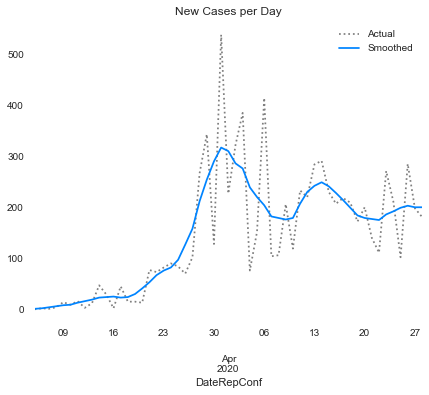

In [14]:
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = cases_per_day.cumsum()
original, smoothed = prepare_cases(cases)

original.plot(title=f"New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 400/72))

ax = smoothed.plot(label='Smoothed', color='#0084ff',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [15]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/4

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.15)

In [16]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

In [17]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
DateRepConf,,,
2020-04-24,1.07,0.77,1.38
2020-04-25,1.10,0.81,1.42
2020-04-26,1.09,0.80,1.40
2020-04-27,1.03,0.75,1.35
2020-04-28,1.02,0.73,1.33


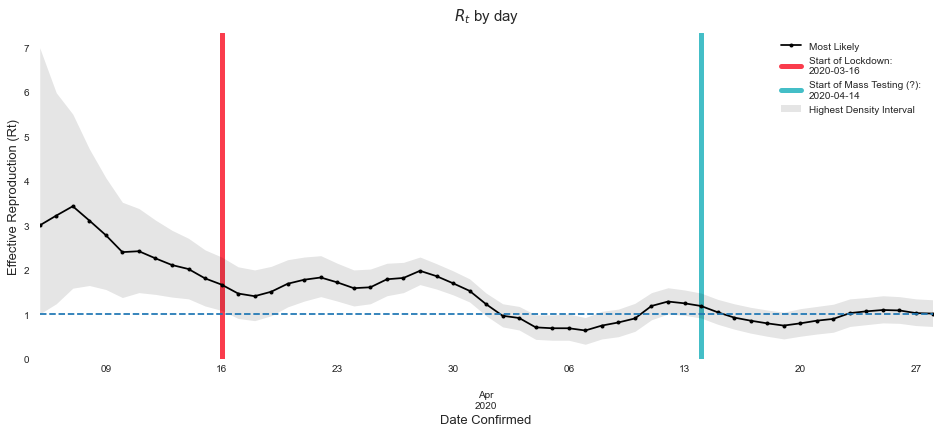

In [18]:
fig, ax = plt.subplots(figsize=(16, 6))
most_likely.plot(marker='o',
                 label='Most Likely',
                 c='k',
                 zorder=2,
                 markersize=4,
                 ax=ax)

ax.fill_between(hdis.index,
                hdis['Low_90'],
                hdis['High_90'],
                color='k',
                zorder=1,
                alpha=.1,
                lw=0,
                label='Highest Density Interval')

ax.axhline(1, linestyle='--')
ax.axvline(most_likely.index[11], linewidth=5,
           zorder=0, color='#fa3c4c',
           label=f'Start of Lockdown: \n{str(most_likely.index[11].date())}')

ax.axvline(most_likely.index[40], linewidth=5,
           zorder=0, color='#44bec7',
           label=f'Start of Mass Testing (?): \n{str(most_likely.index[40].date())}')

ax.set_xlabel('Date Confirmed', size=13)
ax.set_ylabel('Effective Reproduction (Rt)', size=13)
ax.set_title(f'$R_t$ by day', size=15, y=1.02)
ax.legend();

Our current Rt is hovering around 1 which indicates that the spread has been relatively controlled at the national level.

TO DO:
1. Perform optimization of SIGMA
2. Perform province level analysis.

#### Province Level Rt

In [19]:
cases_per_provcity = (df.groupby(['DateRepConf', 'RegionRes'])['CaseCode']
                      .count().reset_index()
                      .pivot(index='DateRepConf',
                             columns='RegionRes',
                             values='CaseCode')
                      .fillna(0).resample('1D').sum())
cases_per_provcity.head()

RegionRes,1,10,11,12,2,3,4A,4B,5,6,7,8,9,BARMM,CAR,CARAGA,NCR
DateRepConf,,,,,,,,,,,,,,,,,
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# cases = cases_per_day.cumsum()
# original, smoothed = prepare_cases(cases)
# posteriors, log_likelihood = get_posteriors(smoothed, sigma=.15)
# hdis = highest_density_interval(posteriors, p=.9)
# most_likely = posteriors.idxmax().rename('ML')

# # Look into why you shift -1
# result = pd.concat([most_likely, hdis], axis=1)

# result.tail()